<a href="https://colab.research.google.com/github/plaban1981/Langchain_usecases/blob/main/integrated_qa_neo4j_langchain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Enhanced Question Answering Integrating Unstructured and Graph Knowledge using Neo4j and LangChain

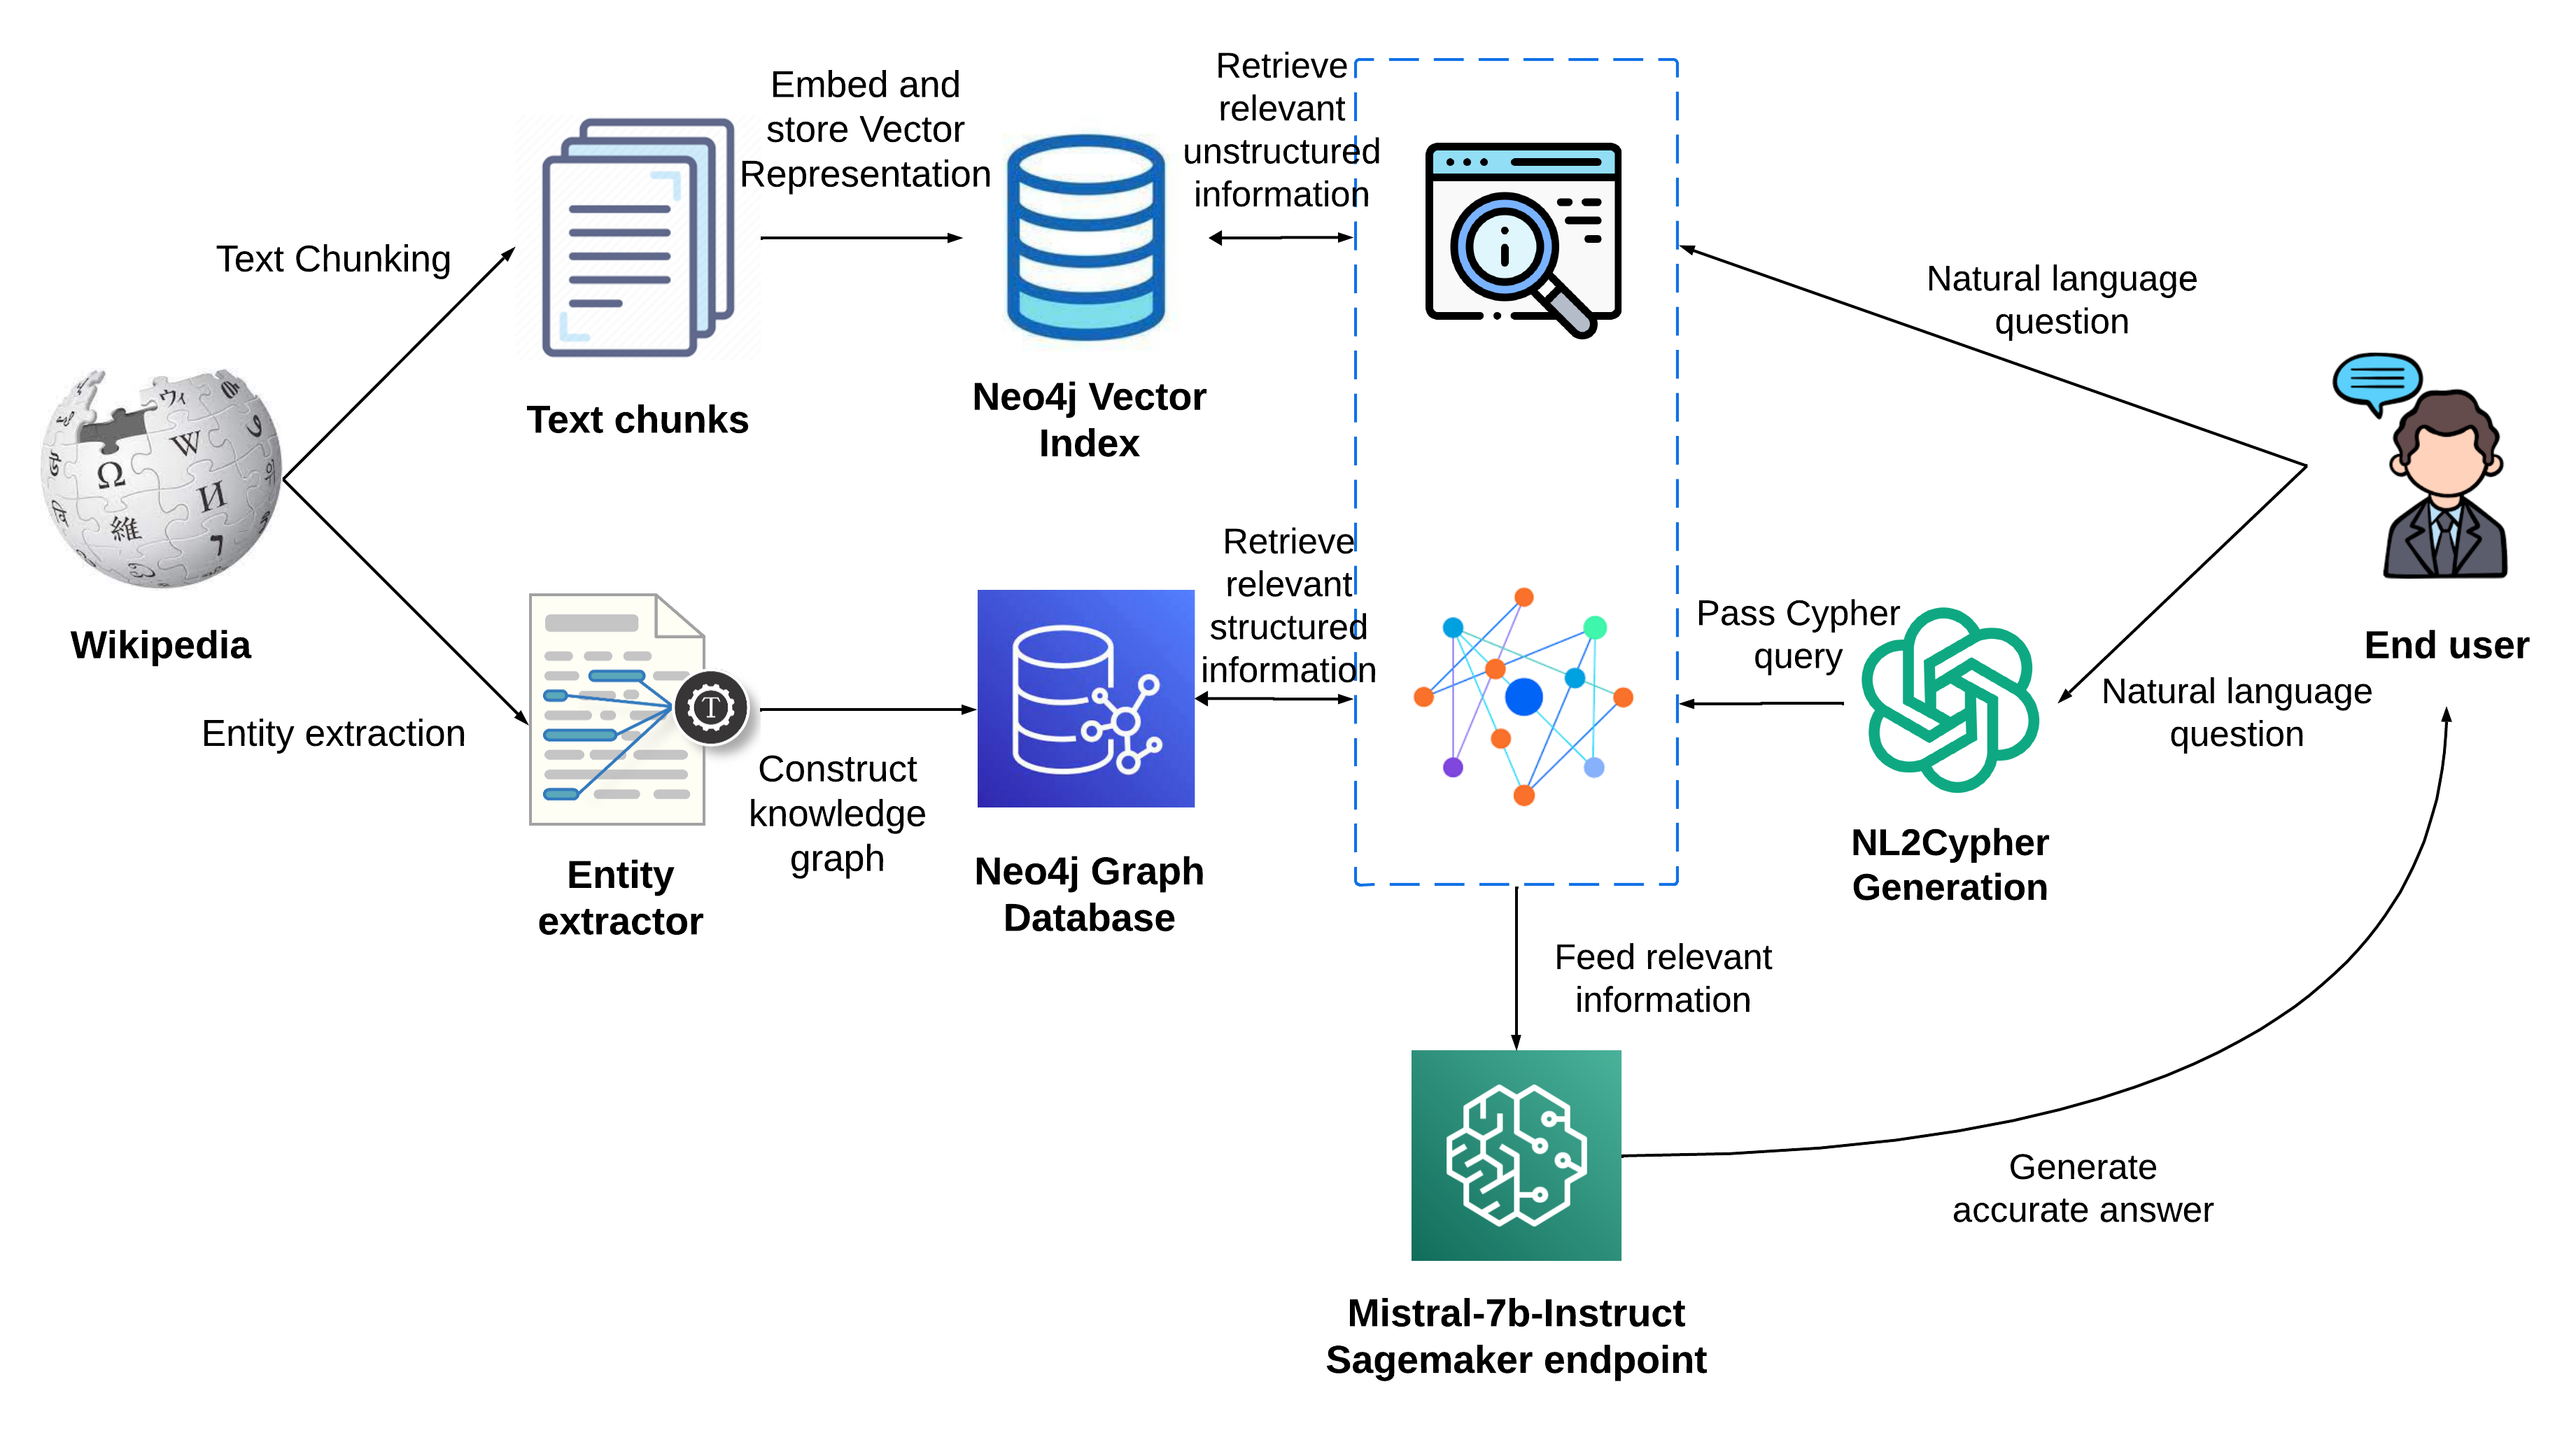

In [9]:
#!pip install -qU neo4j openai langchain tiktoken
%%capture
!pip install  langchain openai wikipedia tiktoken neo4j pypdf transformers llama-cpp-python sentence_transformers

## Knowlwdge Graphs

* The knowledge graphs, which can store both structured and unstructured information in a single database.

* Nodes and relationships are used to describe data in a knowledge graph. Typically, nodes are used to represent entities or concepts like people, organizations, and locations.

* Relationships are used to define connections between these entities, like dependencies

## Neo4j Environment Setup
You need to set up a Neo4j 5.11 or greater to follow along with the examples in this blog post. The easiest way is to start a free instance on Neo4j Aura, which offers cloud instances of Neo4j database. Alternatively, you can also set up a local instance of the Neo4j database by downloading the Neo4j Desktop application and creating a local database instance.

api_key : XWhTJvWZwDzO7m0-AkOfpdV8Q8mDxrBgT-ez9i2v_sI



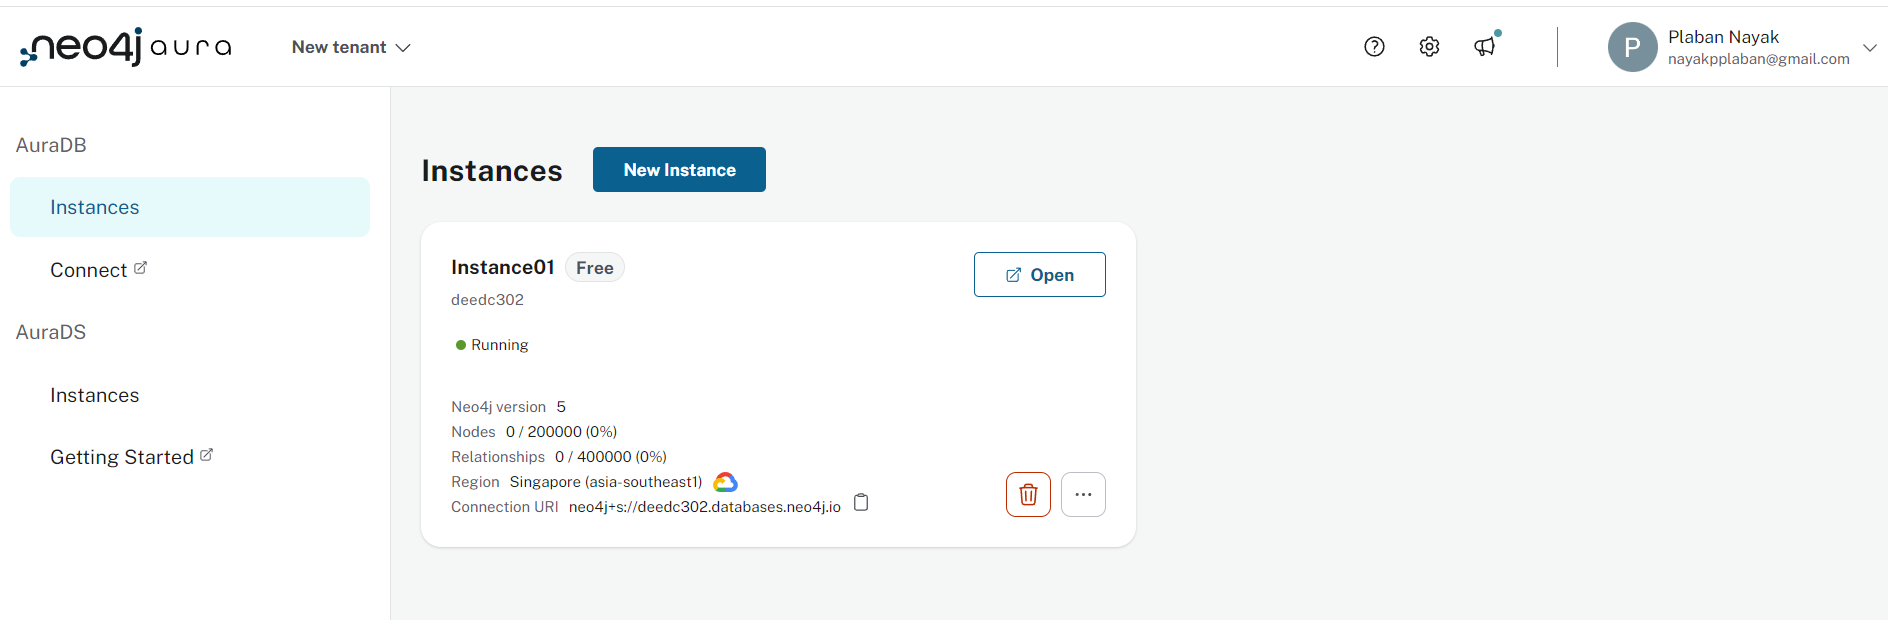

## Neo4j Environment Setup
You need to set up a Neo4j 5.11 or greater to follow along with the examples in this blog post. The easiest way is to start a free instance on Neo4j Aura, which offers cloud instances of Neo4j database. Alternatively, you can also set up a local instance of the Neo4j database by downloading the Neo4j Desktop application and creating a local database instance.

## Setup Openai Key

In [10]:
from getpass import getpass
import os
os.environ["OPENAI_API_KEY"] = getpass("Enter your OpenAI API key: ")
openai_key = os.environ["OPENAI_API_KEY"]

Enter your OpenAI API key: ··········


##  Set up tokenizer
We use the bert-base-uncased model for tokenizing the text. The WikipediaLoader loads the raw content of the specified page, which is then chunked into smaller text pieces using RecursiveCharacterTextSplitter from LangChain. This splitter ensures that each chunk is maximized to 200 tokens with an overlap of 20 tokens, adhering to context window limits for embedding models and making sure that the continuity of the context is not lost.

In [11]:
import os
import re
#from langchain.vectorstores.neo4j_vector import Neo4jVector
from langchain.vectorstores import Neo4jVector
from langchain.document_loaders import WikipediaLoader,PyPDFLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
"""
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def bert_len(text):
    tokens = tokenizer.encode(text)
    return len(tokens)
"""

'\ntokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")\n\ndef bert_len(text):\n    tokens = tokenizer.encode(text)\n    return len(tokens)\n'

## Load the data

In [12]:
from langchain.document_loaders.pdf import PyPDFLoader
file_path = "/content/EVTL_Work_Order_Contract_30SEP10.pdf"
loader = PyPDFLoader(file_path)
raw_documents = loader.load()
len(raw_documents)

6

In [13]:
raw_documents[0].page_content

'29 September 2 010 \n \nMr. Atul Tibrewala  \nDirector, E -Vision Technologies Pvt. Ltd.  \nMUMBAI  \n \nSub: Work Order for Union KBC Project  \n \nDear Sir,  \n \nWith reference to our email & tele -conversation we hereby enclose the final work order drawn on \nE-vision Technologies Pvt. Ltd. (EVTL) along with the applicable terms & conditions.  \n \n1) Scope of Work  \n \nEVTL will provide all necessary services for designing the new web -site internet portal of \nUnion KBC Asset Management Company Pvt. Ltd. & will be responsible for the following \ntasks:  \na) Understanding navigation and application requirements from client.  \nb) Draw up site plan with consultation with client  & Winsoft  \nc) Understand content requirements for each section  \nd) Design templates based on CMS tool selected , for the Internet portal  \ne) Selec t images that need to be bought for the site as and when required.  \nf) Help Winsoft integrate application with design , and where necessary, modify th

In [14]:
from langchain.embeddings import HuggingFaceBgeEmbeddings
model_name = "BAAI/bge-small-en-v1.5"
encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity
embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs={'device': 'cuda'},
    encode_kwargs=encode_kwargs
)

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/90.3k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/134M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [15]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 1000,chunk_overlap=10)
documents = text_splitter.split_documents(raw_documents)
print(documents)

[Document(page_content='29 September 2 010 \n \nMr. Atul Tibrewala  \nDirector, E -Vision Technologies Pvt. Ltd.  \nMUMBAI  \n \nSub: Work Order for Union KBC Project  \n \nDear Sir,  \n \nWith reference to our email & tele -conversation we hereby enclose the final work order drawn on \nE-vision Technologies Pvt. Ltd. (EVTL) along with the applicable terms & conditions.  \n \n1) Scope of Work  \n \nEVTL will provide all necessary services for designing the new web -site internet portal of \nUnion KBC Asset Management Company Pvt. Ltd. & will be responsible for the following \ntasks:  \na) Understanding navigation and application requirements from client.  \nb) Draw up site plan with consultation with client  & Winsoft  \nc) Understand content requirements for each section  \nd) Design templates based on CMS tool selected , for the Internet portal  \ne) Selec t images that need to be bought for the site as and when required.  \nf) Help Winsoft integrate application with design , and whe

In [16]:
print(len(documents))

16


In [17]:
print(documents[0].page_content)

29 September 2 010 
 
Mr. Atul Tibrewala  
Director, E -Vision Technologies Pvt. Ltd.  
MUMBAI  
 
Sub: Work Order for Union KBC Project  
 
Dear Sir,  
 
With reference to our email & tele -conversation we hereby enclose the final work order drawn on 
E-vision Technologies Pvt. Ltd. (EVTL) along with the applicable terms & conditions.  
 
1) Scope of Work  
 
EVTL will provide all necessary services for designing the new web -site internet portal of 
Union KBC Asset Management Company Pvt. Ltd. & will be responsible for the following 
tasks:  
a) Understanding navigation and application requirements from client.  
b) Draw up site plan with consultation with client  & Winsoft  
c) Understand content requirements for each section  
d) Design templates based on CMS tool selected , for the Internet portal  
e) Selec t images that need to be bought for the site as and when required.  
f) Help Winsoft integrate application with design , and where necessary, modify the


#### Neo4jVector requires the Neo4j database credentials

* Neo4j integrates both vector and keyword indexes, which allows you to use a hybrid search approach
* by default it is cosine similarity search

In [21]:
# The Neo4jVector Module will connect to Neo4j and create a vector index if needed.
url = "neo4j+s://deedc302.databases.neo4j.io"
username ="neo4j"
password = "XWhTJvWZwDzO7m0-AkOfpdV8Q8mDxrBgT-ez9i2v_sI"
db = Neo4jVector.from_documents(documents,
                                OpenAIEmbeddings(),
                                url=url,
                                username=username,
                                password=password,
                                search_type="hybrid",
)

## Similarity Search

In [22]:
query = "Who is the director of E-vision Technologies Pvt. Ltd?"
docs_with_score = db.similarity_search_with_score(query, k=2)
#
for doc, score in docs_with_score:
    print("-" * 80)
    print("Score: ", score)
    print(doc.page_content)
    print("-" * 80)

--------------------------------------------------------------------------------
Score:  1.0
29 September 2 010 
 
Mr. Atul Tibrewala  
Director, E -Vision Technologies Pvt. Ltd.  
MUMBAI  
 
Sub: Work Order for Union KBC Project  
 
Dear Sir,  
 
With reference to our email & tele -conversation we hereby enclose the final work order drawn on 
E-vision Technologies Pvt. Ltd. (EVTL) along with the applicable terms & conditions.  
 
1) Scope of Work  
 
EVTL will provide all necessary services for designing the new web -site internet portal of 
Union KBC Asset Management Company Pvt. Ltd. & will be responsible for the following 
tasks:
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Score:  0.9216194152832031
29 September 2 010 
 
Mr. Atul Tibrewala  
Director, E -Vision Technologies Pvt. Ltd.  
MUMBAI  
 
Sub: Work Order for Union KBC Project  
 
Dear Sir,  
 
With reference

In [47]:
docs_with_score

[(Document(page_content='29 September 2 010 \n \nMr. Atul Tibrewala  \nDirector, E -Vision Technologies Pvt. Ltd.  \nMUMBAI  \n \nSub: Work Order for Union KBC Project  \n \nDear Sir,  \n \nWith reference to our email & tele -conversation we hereby enclose the final work order drawn on \nE-vision Technologies Pvt. Ltd. (EVTL) along with the applicable terms & conditions.  \n \n1) Scope of Work  \n \nEVTL will provide all necessary services for designing the new web -site internet portal of \nUnion KBC Asset Management Company Pvt. Ltd. & will be responsible for the following \ntasks:'),
  1.0),
 (Document(page_content='29 September 2 010 \n \nMr. Atul Tibrewala  \nDirector, E -Vision Technologies Pvt. Ltd.  \nMUMBAI  \n \nSub: Work Order for Union KBC Project  \n \nDear Sir,  \n \nWith reference to our email & tele -conversation we hereby enclose the final work order drawn on \nE-vision Technologies Pvt. Ltd. (EVTL) along with the applicable terms & conditions.  \n \n1) Scope of Work  

## Retriever options

In [24]:
retriever = db.as_retriever()
retriever.get_relevant_documents(query)[0]

Document(page_content='29 September 2 010 \n \nMr. Atul Tibrewala  \nDirector, E -Vision Technologies Pvt. Ltd.  \nMUMBAI  \n \nSub: Work Order for Union KBC Project  \n \nDear Sir,  \n \nWith reference to our email & tele -conversation we hereby enclose the final work order drawn on \nE-vision Technologies Pvt. Ltd. (EVTL) along with the applicable terms & conditions.  \n \n1) Scope of Work  \n \nEVTL will provide all necessary services for designing the new web -site internet portal of \nUnion KBC Asset Management Company Pvt. Ltd. & will be responsible for the following \ntasks:')

## Question Answering with Sources

In [30]:
from langchain.chains import RetrievalQAWithSourcesChain, RetrievalQA
from langchain.chat_models import ChatOpenAI

In [44]:
chain = RetrievalQA.from_chain_type(ChatOpenAI(temperature=0),
                                                    chain_type="stuff",
                                                    retriever=retriever,
                                                    )

In [46]:
chain(
    {"query": query},
)

{'query': 'Who is the director of E-vision Technologies Pvt. Ltd?',
 'result': 'The director of E-vision Technologies Pvt. Ltd is Mr. Atul Tibrewala.'}

In [34]:
chain(
    {"query": "Who is Mr. Atul?"},
    return_only_outputs=True,
)

{'result': 'Mr. Atul Tibrewala is the Director of E-Vision Technologies Pvt. Ltd.'}

In [35]:
chain(
    {"query": "Who is Mr. Ravinder Jain?"},
    return_only_outputs=True,
)

{'result': "There is no information provided about Mr. Ravinder Jain in the given context. Therefore, I don't know who Mr. Ravinder Jain is."}

In [36]:
chain(
    {"query": "What is balckhole?"},
    return_only_outputs=True,
)

{'result': 'I\'m sorry, but I don\'t have any information about a "balckhole."'}

In [38]:
chain(
    {"query": "What is blackhole?"},
    return_only_outputs=True,
)

{'result': "I'm sorry, but I don't have enough information to answer your question."}

In [40]:
chain(
    {"query": "What is the scope of work defined from EVTL?.Please answer in a pointwise manner."},
    return_only_outputs=True,
)

{'result': 'The scope of work defined for EVTL includes the following tasks:\n\n1) Understanding navigation and application requirements from the client.\n2) Drawing up a site plan in consultation with the client and Winsoft.\n3) Understanding content requirements for each section of the website.\n4) Designing templates for the internet portal based on the selected CMS tool.\n5) Selecting and purchasing images for the site as needed.\n6) Assisting Winsoft in integrating the application with the design and making necessary modifications.\n7) Delivering any minor changes required by the customer or for technical purposes.\n8) Contributing to the user and system documentation as notified by Winsoft.\n9) Providing full off-site support and warranty for a period of six months after the go-live sign-off by UnionKBC.'}

In [41]:
chain(
    {"query": "What is Indira Gandhi?"},
    return_only_outputs=True,
)

{'result': "Indira Gandhi was the first female Prime Minister of India. She served as Prime Minister from 1966 to 1977 and again from 1980 until her assassination in 1984. She was a prominent political leader and played a significant role in shaping India's political landscape."}

In [42]:
documents[0]

Document(page_content='29 September 2 010 \n \nMr. Atul Tibrewala  \nDirector, E -Vision Technologies Pvt. Ltd.  \nMUMBAI  \n \nSub: Work Order for Union KBC Project  \n \nDear Sir,  \n \nWith reference to our email & tele -conversation we hereby enclose the final work order drawn on \nE-vision Technologies Pvt. Ltd. (EVTL) along with the applicable terms & conditions.  \n \n1) Scope of Work  \n \nEVTL will provide all necessary services for designing the new web -site internet portal of \nUnion KBC Asset Management Company Pvt. Ltd. & will be responsible for the following \ntasks:  \na) Understanding navigation and application requirements from client.  \nb) Draw up site plan with consultation with client  & Winsoft  \nc) Understand content requirements for each section  \nd) Design templates based on CMS tool selected , for the Internet portal  \ne) Selec t images that need to be bought for the site as and when required.  \nf) Help Winsoft integrate application with design , and wher

## Loading existing index

* To load the hybrid search from existing indexes, you have to provide both the vector and keyword indices

In [48]:
index_name = "vector"  # default index name
keyword_index_name = "keyword"  # default keyword index name

store = Neo4jVector.from_existing_index(
    OpenAIEmbeddings(),
    url=url,
    username=username,
    password=password,
    index_name=index_name,
    keyword_index_name=keyword_index_name,
    search_type="hybrid",
)

https://neo4j.com/developer-blog/langchain-library-full-support-neo4j-vector-index/


https://blog.langchain.dev/neo4j-x-langchain-new-vector-index/

## Retriever options from the loaded vector store

In [49]:
query = "Who is Mamta Tibrewalla ?"
retriever = store.as_retriever()
retriever.get_relevant_documents(query)[0]

Document(page_content='a) Project Manager (Mamta Tibrewalla) [All customer interaction]  \nb) 1 Senior Web designer    \nc) 1 Junior Designer    \nEVTL will notify Winsoft with their team member names & contact details, and ens ure that the \nassigned team members are available to work on the UNIONKBC project during the course \nof the project.  \n \n3) Deliverables  \n \nThe significant deliverables expected from EVTL are listed below.  \n \na) All customer interaction documentation related to requireme nt, mock -ups, designs, \ncontent, approvals, and assumptions will be regularly delivered to Winsoft by EVTL.  \nb) EVTL will deliver model template(s) to Winsoft initially for approval from the development')

In [50]:
chain = RetrievalQA.from_chain_type(ChatOpenAI(temperature=0),
                                                    chain_type="stuff",
                                                    retriever=retriever,
                                                    )
#
response = chain(query,return_only_outputs=True)
print(response)

{'result': 'Mamta Tibrewalla is the Project Manager for EVTL. She is responsible for all customer interactions related to the project.'}


In [52]:
response = chain("Describe the Team deployed by EVTL for the project.",return_only_outputs=True)
print(response['result'])

EVTL has deployed the following team for the project:

a) Project Manager (Mamta Tibrewalla) - Responsible for all customer interaction.
b) 1 Senior Web designer - Responsible for designing the web pages.
c) 1 Junior Designer - Assists the senior web designer in the design process.

EVTL will notify Winsoft with the names and contact details of their team members and ensure that they are available to work on the UNIONKBC project throughout its duration.
